Import all Library dependency

In [2]:
import numpy as np
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import os
import cPickle
import matplotlib.pyplot as plt
import numpy as np
import math

Init Bias, Weight, Sparsity Constraint

In [1]:
class SoftmaxAutoEncoder:
    def __init__(self, num_features, num_outputs, list_hidden_layer, learning_rate,
                 corruption_level=0.01,
                 sparsity_parameter=0.01, penalty_parameter=0.01, momentum=0.1,
                 use_sparsity=False, use_momentum=False):

        """
        :param list_hidden_layer: [10, 20] -> means 2 hidden layer, 10 neurons ->layer_1, 10 neurons -> layer_2
        :param corruption_level: made the noise in the data
        :param learning_rate: learning rate
        :param sparsity_parameter: 0.1 -> means 0.1 of neurons is activated
        :param penalty_parameter: learning decay
        """

        list_neurons = [num_features] + list_hidden_layer
        x = T.matrix('x')
        d = T.matrix('d')

        self.total_costs_auto_encoder = []
        self.total_costs_full = []
        self.total_predictions_full = []
        self.list_prev_output = []
        self.reconstructed_image = None
        self.hidden_layer_value = []

        """
            Do the data corruption
        """

        x = self.corrupt_the_data(corruption_level=corruption_level, x=x)

        """
            Construct the auto encoder
        """

        self.weights = []
        biases = []

        prev_output = x

        """
            ENCODER
        """

        for i in range(1, len(list_neurons)):

            weight = init_weights(list_neurons[i-1], list_neurons[i], 'weight_%s' % i)
            bias = init_bias(list_neurons[i], 'bias_%s' % i)

            self.weights.append(weight)
            biases.append(bias)

            prev_output = T.nnet.sigmoid(T.dot(prev_output, weight) + bias)
            self.list_prev_output.append(prev_output)

        """
            DECODER
        """

        buffer_output = prev_output
        biases_trans = []
        list_back_neurons = []

        for i in range(len(self.weights)-1, -1, -1):

            weight_transpose = self.weights[i].transpose()
            bias_transpose = init_bias(list_neurons[i], 'bias_trans_%s' % i)

            biases_trans.append(bias_transpose)

            prev_output = T.nnet.sigmoid(T.dot(prev_output, weight_transpose) + bias_transpose)
            list_back_neurons.append(prev_output)

        # last_output = T.switch(T.gt(prev_output, 0.5), 1, 0)
        cost = - T.mean(T.sum(x * T.log(prev_output) + (1 - x) * T.log(1 - prev_output), axis=1))
        if use_sparsity:
            cost += init_sparsity_constraint(list_back_neurons=list_back_neurons, sparsity_parameter=sparsity_parameter,
                                             penalty_parameter=penalty_parameter)

        # cost = T.mean(T.nnet.binary_crossentropy(prev_output, x))

        params = self.weights+biases+biases_trans
        if not use_momentum:
            grads = T.grad(cost, params)
            updates = [(param, param - learning_rate*grad) for param, grad in zip(params, grads)]
        else:
            updates = sgd_momentum(cost, params, momentum=momentum)

        outputs = [cost, prev_output]
        outputs.extend([p_output for p_output in self.list_prev_output])

        self.train_encoder = theano.function(
            inputs=[x],
            updates=updates,
            outputs=outputs
        )

        """
            TRAIN THE FULL CONNECTED LAYER
        """

        last_weight = init_weights(list_neurons[-1], num_outputs, 'last_weight')
        last_bias = init_bias(num_outputs, 'last_bias')

        buffer_output = T.nnet.softmax(T.dot(buffer_output, last_weight) + last_bias)
        y_pred = T.argmax(buffer_output, axis=1)

        cost_cross = T.mean(T.nnet.categorical_crossentropy(buffer_output, d))

        params_full = self.weights + [last_weight] + biases + [last_bias]
        grads_full = T.grad(cost_cross, params_full)
        updates_full = [(param, param - learning_rate * grad) for param, grad in zip(params_full, grads_full)]

        self.train_cross = theano.function(
            inputs=[x, d],
            updates=updates_full,
            outputs=[prev_output, y_pred, cost_cross]
        )

        self.test_cross = theano.function(
            inputs=[x],
            outputs=[y_pred]
        )

    def corrupt_the_data(self, corruption_level, x):

        # use binomial dist at corrupt the data
        rng = np.random.RandomState(123)
        theano_rng = RandomStreams(rng.randint(2 ** 30))

        tilde_x = theano_rng.binomial(size=x.shape, n=1, p=1 - corruption_level,
                                      dtype=theano.config.floatX) * x

        return tilde_x

    def start_train_auto_encoder(self, epochs, batch_size, train_x, train_y, verbose=False):

        print "Start training the auto encoder"
        self.total_costs_auto_encoder = []

        for epoch in range(epochs):
            # go through trainig set

            costs = []

            for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):

                self.hidden_layer_value = []

                all_value = self.train_encoder(train_x[start:end])
                cost, self.reconstructed_image = all_value[:2]

                for val in all_value[2:]:
                    self.hidden_layer_value.append(val)

                costs.append(cost)

            self.total_costs_auto_encoder.append(np.mean(costs, dtype='float64'))

            if verbose:
                print "Epoch: %d Cost: %s \n" % (epoch, self.total_costs_auto_encoder[epoch])

    def start_train_the_full(self, epochs, batch_size, train_x, train_y, test_x, test_y):

        print "Start training the full hidden layer with autoencoder"
        self.total_costs_full = []
        self.total_predictions_full = []

        for epoch in range(epochs):
            # go through trainng set
            costs = []
            results = []

            for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):
                output, result, cost = self.train_cross(train_x[start:end], train_y[start:end])
                costs.append(cost)
                results.append(np.mean(np.argmax(test_y, axis=1) == self.test_cross(test_x)))

            self.total_costs_full.append(np.mean(costs, dtype='float64'))
            self.total_predictions_full.append(np.mean(results, dtype='float64'))
            print "cost: %s, prediction: %s \n" % (self.total_costs_full[epoch], self.total_predictions_full[epoch])

    def get_total_costs_of_auto_encoder(self):

        return self.total_costs_auto_encoder

    def get_total_cost_and_prediction_full(self):

        return self.total_costs_full, self.total_predictions_full

    def get_weights_on_each_layer(self):

        return [weight.get_value() for weight in self.weights]

    def get_reconstructed_image(self):
        return self.reconstructed_image

    def get_hidden_layer_activation(self):
        return self.hidden_layer_value


Helper function to load data

In [3]:
class DataCollector:

    def __init__(self, file_path):

        with open(file_path, "rb") as input_file:
            self.data = cPickle.load(input_file)

        self.data_train = self.data[0]
        self.data_test = self.data[2]
        self.data_validate = self.data[1]

    def get_train_data(self):

        return self.data_train[0], self.return_one_hot_encoding(10, self.data_train[1])

    def get_test_data(self):

        return self.data_test[0], self.return_one_hot_encoding(10, self.data_test[1])

    def get_validation_data(self):

        return self.data_validate[0], self.return_one_hot_encoding(10, self.data_validate[1])

    def return_one_hot_encoding(self, num_output, list_data):

        zeros = np.zeros((len(list_data), num_output))

        for i in range(len(zeros)):

            zeros[i][list_data[i]] = 1

        return zeros


Load all the train and test data

In [4]:
data_collector = DataCollector("mnist.pkl")

train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()
validate_x, validate_y = data_collector.get_validation_data()

Data visualization task

In [5]:

class DataVisualization:

    def __init__(self):
       return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name):
        plt.figure()
        plt.plot(list_x_point, list_y_point)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.savefig(figure_name)
        plt.show()


class DataVisualizationWithLabels:

    def __init__(self):
       return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name, labels):

        plt.figure()

        for cnt in range(len(labels)):
           plt.plot(list_x_point[cnt], list_y_point[cnt], label=labels[cnt])

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.savefig(figure_name)
        plt.show()


class DataVisualizationAdjacent:

    def __init__(self):
        return

    def show_plot(self, list_data, data, figure_name, number_column=25, limit_image=20, size=28):

        width = height = size
        data = np.array(data).reshape(list_data, width, height)

        plt.figure()
        plt.gray()
        row = limit_image/number_column

        for i in range(1, limit_image+1):
            plt.subplot(row, number_column, i)
            plt.axis('off')
            plt.imshow(data[i-1, :, :])

        plt.savefig(figure_name)
        print 'Finish Plotting'
        plt.show()


Neural Network of Auto Encoder

In [6]:
import numpy as np
from common.utils import init_bias, init_weights, init_sparsity_constraint, sgd_momentum
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams


class SoftmaxAutoEncoder:
    def __init__(self, num_features, num_outputs, list_hidden_layer, learning_rate,
                 corruption_level=0.01,
                 sparsity_parameter=0.01, penalty_parameter=0.01, momentum=0.1,
                 use_sparsity=False, use_momentum=False):

        """
        :param list_hidden_layer: [10, 20] -> means 2 hidden layer, 10 neurons ->layer_1, 10 neurons -> layer_2
        :param corruption_level: made the noise in the data
        :param learning_rate: learning rate
        :param sparsity_parameter: 0.1 -> means 0.1 of neurons is activated
        :param penalty_parameter: learning decay
        """

        list_neurons = [num_features] + list_hidden_layer
        x = T.matrix('x')
        d = T.matrix('d')

        self.total_costs_auto_encoder = []
        self.total_costs_full = []
        self.total_predictions_full = []
        self.reconstructed_image = None

        """
            Do the data corruption
        """

        x = self.corrupt_the_data(corruption_level=corruption_level, x=x)

        """
            Construct the auto encoder
        """

        self.weights = []
        biases = []

        prev_output = x

        """
            ENCODER
        """

        for i in range(1, len(list_neurons)):

            weight = init_weights(list_neurons[i-1], list_neurons[i], 'weight_%s' % i)
            bias = init_bias(list_neurons[i], 'bias_%s' % i)

            self.weights.append(weight)
            biases.append(bias)

            prev_output = T.nnet.sigmoid(T.dot(prev_output, weight) + bias)

        """
            DECODER
        """

        buffer_output = prev_output
        biases_trans = []
        list_back_neurons = []

        for i in range(len(self.weights)-1, -1, -1):

            weight_transpose = self.weights[i].transpose()
            bias_transpose = init_bias(list_neurons[i], 'bias_trans_%s' % i)

            biases_trans.append(bias_transpose)

            prev_output = T.nnet.sigmoid(T.dot(prev_output, weight_transpose) + bias_transpose)
            list_back_neurons.append(prev_output)

        # last_output = T.switch(T.gt(prev_output, 0.5), 1, 0)
        cost = - T.mean(T.sum(x * T.log(prev_output) + (1 - x) * T.log(1 - prev_output), axis=1))
        if use_sparsity:
            cost += init_sparsity_constraint(list_back_neurons=list_back_neurons, sparsity_parameter=sparsity_parameter,
                                             penalty_parameter=penalty_parameter)

        # cost = T.mean(T.nnet.binary_crossentropy(prev_output, x))

        params = self.weights+biases+biases_trans
        if not use_momentum:
            grads = T.grad(cost, params)
            updates = [(param, param - learning_rate*grad) for param, grad in zip(params, grads)]
        else:
            updates = sgd_momentum(cost, params, momentum=momentum)

        outputs = [cost, prev_output]

        self.train_encoder = theano.function(
            inputs=[x],
            updates=updates,
            outputs=outputs
        )

        """
            TRAIN THE FULL CONNECTED LAYER
        """

        last_weight = init_weights(list_neurons[-1], num_outputs, 'last_weight')
        last_bias = init_bias(num_outputs, 'last_bias')

        buffer_output = T.nnet.softmax(T.dot(buffer_output, last_weight) + last_bias)
        y_pred = T.argmax(buffer_output, axis=1)

        cost_cross = T.mean(T.nnet.categorical_crossentropy(buffer_output, d))

        params_full = self.weights + [last_weight] + biases + [last_bias]
        grads_full = T.grad(cost_cross, params_full)
        updates_full = [(param, param - learning_rate * grad) for param, grad in zip(params_full, grads_full)]

        self.train_cross = theano.function(
            inputs=[x, d],
            updates=updates_full,
            outputs=[prev_output, y_pred, cost_cross]
        )

        self.test_cross = theano.function(
            inputs=[x],
            outputs=[y_pred]
        )

    def corrupt_the_data(self, corruption_level, x):

        # use binomial dist at corrupt the data
        rng = np.random.RandomState(123)
        theano_rng = RandomStreams(rng.randint(2 ** 30))

        tilde_x = theano_rng.binomial(size=x.shape, n=1, p=1 - corruption_level,
                                      dtype=theano.config.floatX) * x

        return tilde_x

    def start_train_auto_encoder(self, epochs, batch_size, train_x, train_y, verbose=False):

        print "Start training the auto encoder"
        self.total_costs_auto_encoder = []
        
        for epoch in range(epochs):
            # go through trainig set

            costs = []

            for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):
                cost, self.reconstructed_image = self.train_encoder(train_x[start:end])
                costs.append(cost)

            self.total_costs_auto_encoder.append(np.mean(costs, dtype='float64'))

            if verbose:
                print "Epoch: %d Cost: %s \n" % (epoch, self.total_costs_auto_encoder[epoch])

    def start_train_the_full(self, epochs, batch_size, train_x, train_y, test_x, test_y):

        print "Start training the full hidden layer with autoencoder"
        self.total_costs_full = []
        self.total_predictions_full = []

        for epoch in range(epochs):
            # go through trainng set
            costs = []
            results = []

            for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):
                output, result, cost = self.train_cross(train_x[start:end], train_y[start:end])
                costs.append(cost)
                results.append(np.mean(np.argmax(test_y, axis=1) == self.test_cross(test_x)))

            self.total_costs_full.append(np.mean(costs, dtype='float64'))
            self.total_predictions_full.append(np.mean(results, dtype='float64'))
            print "cost: %s, prediction: %s \n" % (self.total_costs_full[epoch], self.total_predictions_full[epoch])

    def get_total_costs_of_auto_encoder(self):

        return self.total_costs_auto_encoder

    def get_total_cost_and_prediction_full(self):

        return self.total_costs_full, self.total_predictions_full

    def get_weights_on_each_layer(self):

        return [weight.get_value() for weight in self.weights]

    def get_reconstructed_image(self):
        return self.reconstructed_image


This part of assignment aims to provide you with some exposure to the use of autoencoders. Use
the full MNIST dataset for this problem.
Hints: Use corruption level = 0.1, training epochs = up to about 25, learning rate = 0.1, and batch
size = 128 for training of all the layers. 

1) Design a stacked denoising autoencoder consisting of three hidden-layers; 900 neurons in the
first hidden-layer, 625 neurons in the second hidden-layer, and 400 neurons in the third
hidden-layer. To train the network:
- Use the training dataset of MNIST digits
- Corrupt the input data using a binomial distribution at 10% corruption level.
- Use cross-entropy as the cost function

Plot

- a. learning curves for training each layer
- b. Plot 100 samples of weights (as images) learned at each layer
- c. For 100 representative test images plot: 
    - reconstructed images by the network. 
    - Hidden layer activation 

a. Learning curve for training each layer.

Start training the auto encoder
Epoch: 0 Cost: 174.43376592 

Epoch: 1 Cost: 97.5394988777 

Epoch: 2 Cost: 82.7679948596 

Epoch: 3 Cost: 76.372673232 

Epoch: 4 Cost: 72.771762592 

Epoch: 5 Cost: 70.3794151958 

Epoch: 6 Cost: 68.6324411069 

Epoch: 7 Cost: 67.2352926709 

Epoch: 8 Cost: 66.1587345805 

Epoch: 9 Cost: 65.3900361278 

Epoch: 10 Cost: 64.4937351194 

Epoch: 11 Cost: 63.8701360255 

Epoch: 12 Cost: 63.4479220939 

Epoch: 13 Cost: 62.8377373409 

Epoch: 14 Cost: 62.4317023955 

Epoch: 15 Cost: 62.1077329365 

Epoch: 16 Cost: 61.7225732605 

Epoch: 17 Cost: 61.4116460617 

Epoch: 18 Cost: 61.0696628426 

Epoch: 19 Cost: 60.8495147728 

Epoch: 20 Cost: 60.5791241675 

Epoch: 21 Cost: 60.3662058608 

Epoch: 22 Cost: 60.1360554617 

Epoch: 23 Cost: 59.949197536 

Epoch: 24 Cost: 59.7418773082 



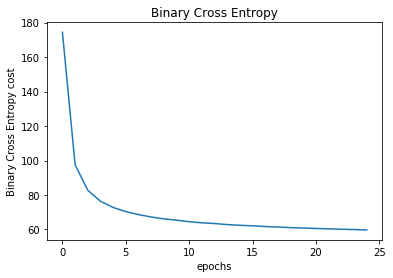

In [7]:
num_feature = len(train_x[0])
list_hidden_layer = [900,625,400]
epochs = 25
batch_size = 128
num_output = 10

softmax = SoftmaxAutoEncoder(num_features=num_feature, num_outputs=num_output,
                             list_hidden_layer=list_hidden_layer, learning_rate=0.1)

softmax.start_train_auto_encoder(epochs=epochs, batch_size=batch_size,
                                 train_x=train_x, train_y=train_y, verbose=True)

list_cost = softmax.get_total_costs_of_auto_encoder()

visualizer = DataVisualization()

%matplotlib inline

visualizer.show_plot(list_x_point=range(epochs),
                     list_y_point=list_cost,
                     x_label='epochs',
                     y_label='Binary Cross Entropy cost',
                     title='Binary Cross Entropy',
                     figure_name='project_b/images/1a_cost.png')

b. Plot 100 samples of weights (as images) learned at each layer

In [8]:
list_weights = softmax.get_weights_on_each_layer()
hidden_layer_activation = softmax.get_hidden_layer_activation()
number_column = 25
visualizer = DataVisualizationAdjacent()

b.1. plot first layer of auto encoder.

Finish Plotting


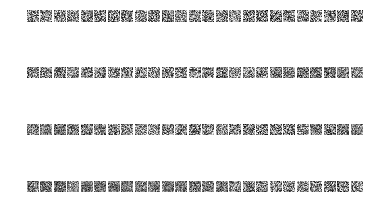

In [9]:
%matplotlib inline
number_layer = 0
visualizer.show_plot\
    (list_data=list_hidden_layer[number_layer],
     data=list_weights[number_layer], 
     figure_name="project_b/images/1b_auto_first.png",
     number_column=number_column,
     limit_image=100,
     size=28
)


b.2. plot second layer of auto encoder

Finish Plotting


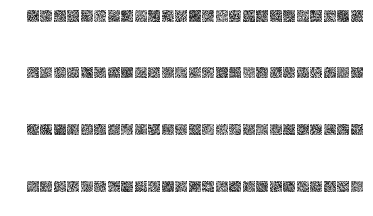

In [10]:
%matplotlib inline
number_layer = 1
visualizer.show_plot\
    (list_data=list_hidden_layer[number_layer],
     data=list_weights[number_layer], 
     figure_name="project_b/images/1b_auto_first.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1]))
)


b.3. Plot third layer of auto encoder

Finish Plotting


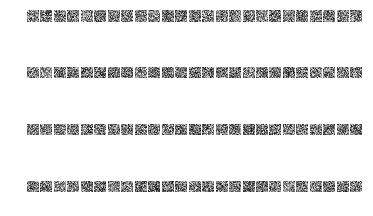

In [11]:
%matplotlib inline
number_layer = 2
visualizer.show_plot\
    (list_data=list_hidden_layer[number_layer],
     data=list_weights[number_layer], 
     figure_name="project_b/images/1b_auto_first.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1]))
)


c. For 100 representative test images plot
- reconstructed images by the network.
- Hidden layer activation

### Reconstructed images of the network

Finish Plotting


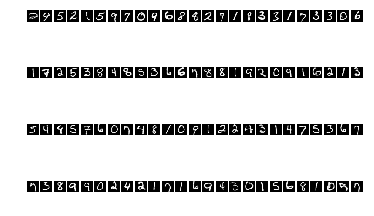

In [12]:
# get the reconstructed images
reconstructed_images = softmax.get_reconstructed_image()
visualizer.show_plot \
    (list_data=batch_size,
     data=reconstructed_images,
     figure_name="./project_b/images/1c_reconstructed_image.png",
     number_column=number_column,
     limit_image=100,
     size=28
    )


### Hidden layer activation

In [ ]:
for val_hidden_layer in hidden_layer_activation:
    visualizer.show_plot\
        (list_data=batch_size,
         data=val_hidden_layer,
         figure_name="images/1c_reconstructed_image.png",
         number_column=number_column,
         limit_image=100,
         size=int(math.sqrt(len(val_hidden_layer[0])))
    )

2.Train a five-layer feedforward neural network to recognize MNIST data, initialized by the three
hidden layers learned in part (1) and by adding a softmax layer as the output layer. Plot the
training errors and test accuracies during training.

Start training the full hidden layer with autoencoder
cost: 0.547797196287, prediction: 0.842104615385 

cost: 0.248837858776, prediction: 0.92991025641 

cost: 0.200947401663, prediction: 0.942193333333 

cost: 0.173706840228, prediction: 0.948761794872 

cost: 0.154849666895, prediction: 0.953002564103 

cost: 0.140548191397, prediction: 0.95619 

cost: 0.129106114422, prediction: 0.958556153846 

cost: 0.119623370527, prediction: 0.960444358974 

cost: 0.111565538963, prediction: 0.962053076923 

cost: 0.10458938496, prediction: 0.963436153846 

cost: 0.0984612994935, prediction: 0.964658974359 

cost: 0.0930150802545, prediction: 0.965719230769 

cost: 0.0881282890487, prediction: 0.966642051282 

cost: 0.0837081581975, prediction: 0.967456153846 

cost: 0.0796827521959, prediction: 0.968181282051 

cost: 0.0759951905672, prediction: 0.968841025641 

cost: 0.0725997421394, prediction: 0.969439487179 

cost: 0.0694591100372, prediction: 0.969977179487 

cost: 0.0665424990458, predic

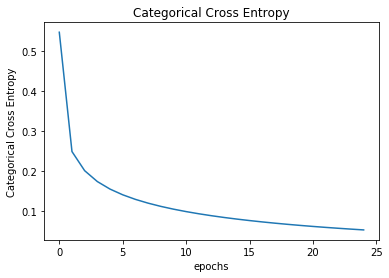

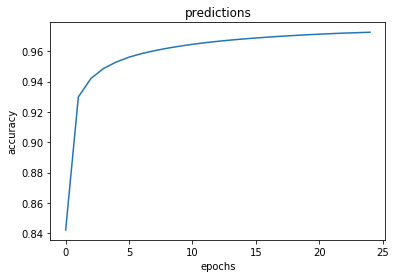

In [13]:
epochs = 25
batch_size = 128

softmax.start_train_the_full(epochs=epochs, batch_size=batch_size,
                             train_x=train_x, train_y=train_y,
                             test_x=test_x, test_y=test_y)  


list_cost, list_prediction = softmax.get_total_cost_and_prediction_full()

visualizer = DataVisualization()

%matplotlib inline

visualizer.show_plot(list_x_point=range(epochs),
                     list_y_point=list_cost,
                     x_label='epochs',
                     y_label='Categorical Cross Entropy',
                     title='Categorical Cross Entropy',
                     figure_name='project_b/images/2_cost.png')


visualizer.show_plot(list_x_point=range(epochs),
                     list_y_point=list_prediction,
                     x_label='epochs',
                     y_label='accuracy',
                     title='predictions',
                     figure_name='project_b/images/2_prediction.png')



3) Repeat part (1) and (2) by introducing the momentum term for gradient descent learning and
the sparsity constraint to the cost function. Choose momentum parameter 𝛾 = 0.1, penalty
parameter 𝛽 = 0.5, and sparsity parameter 𝜌 = 0.05. Compare the results with those of part
(1) and (2)

#### 3.1. Compare result from point 1

Compare result from 1.a

In [1]:
num_feature = len(train_x[0])
list_hidden_layer = [900,625,400]
epochs = 25
batch_size = 128
num_output = 10
momentum = 0.1
sparsity_parameter = 0.05
penalty_parameter = 0.5

softmax_momentum_sparsity = SoftmaxAutoEncoder(
    num_features=num_feature, num_outputs=num_output,
    list_hidden_layer=list_hidden_layer, learning_rate=0.1,
    sparsity_parameter=sparsity_parameter, penalty_parameter=penalty_parameter,
    momentum=momentum, use_sparsity=True, use_momentum=True
)

softmax_momentum_sparsity.start_train_auto_encoder(epochs=epochs, batch_size=batch_size,
                                 train_x=train_x, train_y=train_y, verbose=True)

list_cost_momentum_sparsity = softmax_momentum_sparsity.get_total_costs_of_auto_encoder()
list_normal_cost = softmax.get_total_costs_of_auto_encoder()

visualizer = DataVisualizationWithLabels()

%matplotlib inline

visualizer.show_plot(list_x_point=[range(epochs) for k in range(2)],
                     list_y_point=[list_cost_momentum_sparsity, list_cost],
                     x_label='epochs',
                     y_label='Binary Cross Entropy cost',
                     title='Binary Cross Entropy',
                     figure_name='project_b/images/1a_cost.png',
                     labels=['cost with momentum and sparsity', 'cost']  
                    )

NameError: name 'train_x' is not defined

Compare result from 1.b first layer

In [16]:
list_weights_sparsity_momentum = softmax_momentum_sparsity.get_weights_on_each_layer()
list_weights = softmax.get_weights_on_each_layer() 
hidden_layer_activation_softmax = softmax_momentum_sparsity.get_hidden_layer_activation()
number_column = 25
visualizer = DataVisualizationAdjacent()

Finish Plotting


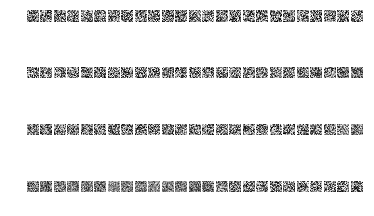

In [17]:
%matplotlib inline
number_layer = 0
visualizer.show_plot\
    (list_data=list_hidden_layer[number_layer],
     data=list_weights_sparsity_momentum[number_layer], 
     figure_name="project_b/images/3b_auto_first.png",
     number_column=number_column,
     limit_image=100,
     size=28
)


Compare result from 1.b. second layer 

Finish Plotting


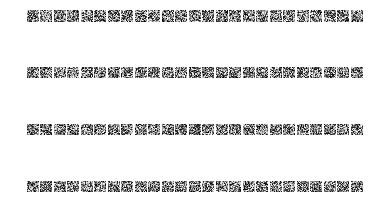

In [18]:
%matplotlib inline
number_layer = 1
visualizer.show_plot\
    (list_data=list_hidden_layer[number_layer],
     data=list_weights_sparsity_momentum[number_layer], 
     figure_name="project_b/images/3b_auto_second.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1]))
)


Compare result from 1.b third layer

Finish Plotting


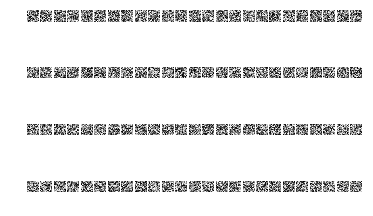

In [19]:
%matplotlib inline
number_layer = 2
visualizer.show_plot\
    (list_data=list_hidden_layer[number_layer],
     data=list_weights_sparsity_momentum[number_layer], 
     figure_name="project_b/images/3b_auto_third.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1]))
)


Compare result from 1.c 

### Reconstrucred images

Finish Plotting


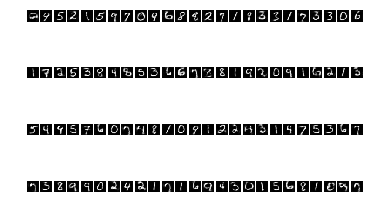

In [20]:
# get the reconstructed images
reconstructed_images = softmax_momentum_sparsity.get_reconstructed_image()
visualizer.show_plot \
    (list_data=batch_size,
     data=reconstructed_images,
     figure_name="./project_b/images/3c_reconstructed_image.png",
     number_column=number_column,
     limit_image=100,
     size=28
    )


### Hidden layer activation

In [ ]:
for val_hidden_layer in hidden_layer_activation_softmax:
    visualizer.show_plot\
        (list_data=batch_size,
         data=val_hidden_layer,
         figure_name="images/1c_reconstructed_image.png",
         number_column=number_column,
         limit_image=100,
         size=int(math.sqrt(len(val_hidden_layer[0])))
    )

#### compare result from 2

Start training the full hidden layer with autoencoder
cost: 0.486344009738, prediction: 0.864656923077 

cost: 0.262615622316, prediction: 0.927981538462 

cost: 0.218228583831, prediction: 0.93891 

cost: 0.192313688454, prediction: 0.944877179487 

cost: 0.174155271631, prediction: 0.949017692308 

cost: 0.160192026924, prediction: 0.952143076923 

cost: 0.148857080426, prediction: 0.954607948718 

cost: 0.139331907484, prediction: 0.956630512821 

cost: 0.131133361036, prediction: 0.958368461538 

cost: 0.12395045369, prediction: 0.959923846154 

cost: 0.117570182931, prediction: 0.961327948718 

cost: 0.111839968672, prediction: 0.962612051282 

cost: 0.106646767707, prediction: 0.963758205128 

cost: 0.10190455095, prediction: 0.964784102564 

cost: 0.097546379151, prediction: 0.965731025641 

cost: 0.0935191780491, prediction: 0.96661025641 

cost: 0.0897801698514, prediction: 0.967411538462 

cost: 0.0862943663035, prediction: 0.968143076923 

cost: 0.0830327719092, prediction: 

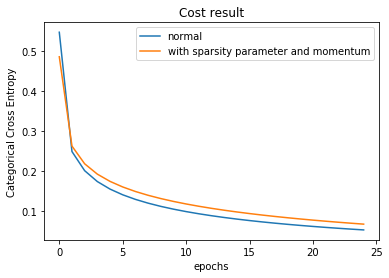

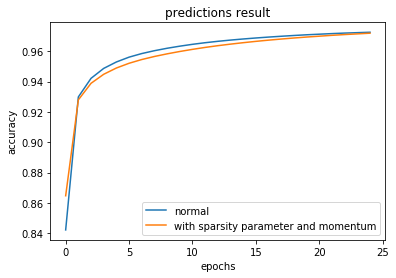

In [21]:
epochs = 25
batch_size = 128

softmax_momentum_sparsity.start_train_the_full(epochs=epochs, batch_size=batch_size,
                             train_x=train_x, train_y=train_y,
                             test_x=test_x, test_y=test_y)  


list_cost_spar_mom, list_prediction_spar_mom = softmax_momentum_sparsity.get_total_cost_and_prediction_full()
list_cost, list_prediction = softmax.get_total_cost_and_prediction_full()

visualizer = DataVisualizationWithLabels()

%matplotlib inline

visualizer.show_plot(list_x_point=[range(epochs) for k in range(2)],
                     list_y_point=[list_cost, list_cost_spar_mom],
                     x_label='epochs',
                     y_label='Categorical Cross Entropy',
                     title='Cost result',
                     figure_name='project_b/images/3_cost.png',
                     labels=['normal', 'with sparsity parameter and momentum']
                    )


visualizer.show_plot(list_x_point=[range(epochs) for k in range(2)],
                     list_y_point=[list_prediction, list_prediction_spar_mom],
                     x_label='epochs',
                     y_label='accuracy',
                     title='predictions result',
                     figure_name='project_b/images/3_prediction.png',
                     labels=['normal', 'with sparsity parameter and momentum']
                    )